In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import csv

#Import Graph file

In [ ]:
file_path = '/content/drive/MyDrive/Assignment/web-Google.txt'

def read_and_print_first_5_elements(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        print(lines[0].strip())

        for line in lines[1:6]:
            print(line.strip())

read_and_print_first_5_elements(file_path)

FromNodeId	ToNodeId
0	11342
0	824020
0	867923
0	891835
11342	0


#Function for converting txt file to csv file

In [ ]:
def save_as_csv(file_path, csv_file='nodes.csv'):

    header = ['FromNodeId', 'ToNodeId']
    rows = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

        for line in lines[4:]:
            if line.strip():
                rows.append(line.strip().split())

    with open(csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)
        writer.writerows(rows)

    print(f"Data saved successfully to {csv_file}")

In [ ]:
def print_head_csv(csv_file, num_rows=5):
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        for i, row in enumerate(reader):
            if i < num_rows:
                print(row)

In [ ]:
file_path = '/content/drive/MyDrive/Assignment/web-Google.txt'

save_as_csv(file_path)

print("First 5 rows of nodes.csv:")
print_head_csv('nodes.csv')

Data saved successfully to nodes.csv
First 5 rows of nodes.csv:
['FromNodeId', 'ToNodeId']
['0', '891835']
['11342', '0']
['11342', '27469']
['11342', '38716']


#Functions for calculating pagerank

In [ ]:
def stothers_williams_multiply(A, B):
    return np.dot(A, B)

In [ ]:
def pagerank_sw(adjacency_matrix, alpha=0.85, tol=1e-6, max_iter=100):
    n = adjacency_matrix.shape[0]
    row_sums = adjacency_matrix.sum(axis=1, keepdims=True)
    transition_matrix = adjacency_matrix / row_sums
    transition_matrix[np.isnan(transition_matrix)] = 1 / n

    pagerank_scores = np.ones(n) / n
    convergence_tracking = [pagerank_scores.copy()]
    start_time = time.time()

    for iteration in range(max_iter):
        new_pagerank_scores = alpha * stothers_williams_multiply(transition_matrix.T, pagerank_scores) + (1 - alpha) / n
        convergence_tracking.append(new_pagerank_scores.copy())

        if np.linalg.norm(new_pagerank_scores - pagerank_scores, 1) < tol:
            pagerank_scores = new_pagerank_scores
            break
        pagerank_scores = new_pagerank_scores

    computation_time = time.time() - start_time
    num_iterations = iteration + 1
    node_pagerank = {i: pr for i, pr in enumerate(pagerank_scores)}

    return pagerank_scores, computation_time, num_iterations, convergence_tracking, node_pagerank

In [ ]:
def pagerank_google(adjacency_matrix, alpha=0.85, tol=1e-6, max_iter=100):
    n = adjacency_matrix.shape[0]
    dangling_weights = np.where(adjacency_matrix.sum(axis=1) == 0)[0]

    S = np.copy(adjacency_matrix)
    S[np.where(S.sum(axis=1) == 0), :] = 1
    S /= S.sum(axis=1)[:, np.newaxis]
    P = alpha * S + (1 - alpha) * np.ones((n, n)) / n
    pi = np.ones(n) / n
    last_pi = np.zeros(n)
    start_time = time.time()

    for iteration in range(max_iter):
        last_pi = pi.copy()
        pi = P.T.dot(pi) + (1 - alpha) * np.sum(last_pi[dangling_weights]) / n

        if np.linalg.norm(pi - last_pi, 1) < tol:
            break

    computation_time = time.time() - start_time
    node_pagerank = {i: pr for i, pr in enumerate(pi)}

    return pi, computation_time, iteration + 1, None, node_pagerank

In [ ]:
def get_top_pagerank_nodes(node_pagerank, top_n=10):
    sorted_nodes = sorted(node_pagerank.items(), key=lambda x: x[1], reverse=True)
    top_nodes = sorted_nodes[:top_n]
    return top_nodes

In [ ]:
def plot_convergence(convergence_tracking, top_nodes, algorithm_name):
    plt.figure(figsize=(10, 6))
    for i in range(len(top_nodes)):
        node_id, _ = top_nodes[i]
        scores = [scores[node_id] for scores in convergence_tracking]
        plt.plot(scores, label=f'Top {i+1} Node {node_id}', alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel('PageRank Score')
    plt.title(f'PageRank Convergence Over Iterations - {algorithm_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_network_graph(adjacency_matrix, pr_custom, pr_google, top_nodes_custom, top_nodes_google):
    G = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

    plt.figure(figsize=(12, 8))

    top_node_ids_custom = [node_id for node_id, _ in top_nodes_custom]
    top_node_scores_custom = np.array([pr_custom[node_id] for node_id, _ in top_nodes_custom])

    top_node_ids_google = [node_id for node_id, _ in top_nodes_google]
    top_node_scores_google = np.array([pr_google[node_id] for node_id, _ in top_nodes_google])

    sizes_custom = 1000 * top_node_scores_custom / np.max(top_node_scores_custom)
    colors_custom = top_node_scores_custom / np.max(top_node_scores_custom)

    sizes_google = 1000 * top_node_scores_google / np.max(top_node_scores_google)
    colors_google = top_node_scores_google / np.max(top_node_scores_google)

    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, nodelist=top_node_ids_custom, node_size=sizes_custom, node_color=colors_custom, cmap=plt.cm.Blues, label='Custom PageRank')
    nx.draw_networkx_nodes(G, pos, nodelist=top_node_ids_google, node_size=sizes_google, node_color=colors_google, cmap=plt.cm.Reds, label='Google PageRank')
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title('Network Graph of Web Pages with PageRank Scores')
    plt.legend()
    plt.axis('off')
    plt.show()

In [ ]:
def plot_convergence_comparison(conv_tracking_sw, conv_tracking_google, top_nodes_sw, top_nodes_google):
    fig, axs = plt.subplots(2, figsize=(8, 8))

    for i in range(len(top_nodes_sw)):
        node_id, _ = top_nodes_sw[i]
        scores_sw = [scores[node_id] for scores in conv_tracking_sw]
        axs[0].plot(scores_sw, label=f'Top')

#Import csv file


In [ ]:
df = pd.read_csv('nodes.csv')
print(df.columns)

from_node_ids = df['FromNodeId'].values
to_node_ids = df['ToNodeId'].values

all_node_ids = np.concatenate([from_node_ids, to_node_ids])
unique_node_ids, node_counts = np.unique(all_node_ids, return_counts=True)

top_node_ids = unique_node_ids[np.argsort(node_counts)][-20000:]

num_nodes = len(top_node_ids)
adjacency_matrix = np.zeros((num_nodes, num_nodes))

for from_id, to_id in zip(from_node_ids, to_node_ids):
    if from_id in top_node_ids and to_id in top_node_ids:
        adjacency_matrix[np.where(top_node_ids == from_id)[0][0], np.where(top_node_ids == to_id)[0][0]] = 1

pr_scores_sw, comp_time_sw, num_iter_sw, conv_tracking_sw, node_pagerank_sw = pagerank_sw(adjacency_matrix)
pr_scores_google, comp_time_google, num_iter_google, conv_tracking_google, node_pagerank_google = pagerank_google(adjacency_matrix)

top_nodes_sw = get_top_pagerank_nodes(node_pagerank_sw)
top_nodes_google = get_top_pagerank_nodes(node_pagerank_google)

Index(['FromNodeId', 'ToNodeId'], dtype='object')


<ipython-input-8-700f1c9898f1>:4: RuntimeWarning: invalid value encountered in divide
  transition_matrix = adjacency_matrix / row_sums


In [ ]:
print("Results for Proposed PageRank Algorithm:")
print(f"Computation Time: {comp_time_sw:.4f} seconds")
print("\nTop 10 Nodes with Highest PageRank:")
for node_id, score in top_nodes_sw:
    print(f"Node ID: {node_id}, PageRank Score: {score}")

print("\nResults for Google's PageRank Algorithm:")
print(f"Computation Time: {comp_time_google:.4f} seconds")
print("\nTop 10 Nodes with Highest PageRank:")
for node_id, score in top_nodes_google:
    print(f"Node ID: {node_id}, PageRank Score: {score}")

Results for Proposed PageRank Algorithm:
Computation Time: 16.8607 seconds

Top 10 Nodes with Highest PageRank:
Node ID: 19977, PageRank Score: 0.0029047918242183063
Node ID: 19998, PageRank Score: 0.002078822667582055
Node ID: 19972, PageRank Score: 0.0017555652275419585
Node ID: 19997, PageRank Score: 0.0016707053856860649
Node ID: 19988, PageRank Score: 0.001593048766288159
Node ID: 19968, PageRank Score: 0.001566944999423347
Node ID: 19993, PageRank Score: 0.001562838069439514
Node ID: 19995, PageRank Score: 0.0015459466368170783
Node ID: 13616, PageRank Score: 0.0014957432186909687
Node ID: 19999, PageRank Score: 0.0014636361117725506

Results for Google's PageRank Algorithm:
Computation Time: 29.4072 seconds

Top 10 Nodes with Highest PageRank:
Node ID: 19977, PageRank Score: 0.005325687096184699
Node ID: 19998, PageRank Score: 0.003846847322556738
Node ID: 19972, PageRank Score: 0.0032642586440907386
Node ID: 19997, PageRank Score: 0.003093661801124046
Node ID: 19988, PageRank S

#Graphical Analysis

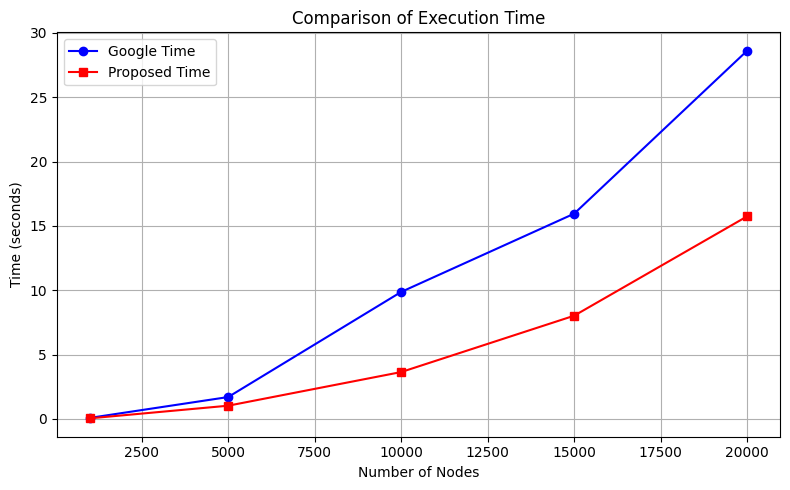

In [ ]:
NumofNodes = [1000, 5000, 10000, 15000, 20000]
GoogleTime = [0.0833, 1.7036, 9.8697, 15.9501, 28.6114]
ProposedTime = [0.0492, 1.0310, 3.6450, 8.0227, 15.7427]

plt.figure(figsize=(8, 5))

plt.plot(NumofNodes,GoogleTime, marker='o', linestyle='-', color='b', label='Google Time')
plt.plot( NumofNodes,ProposedTime, marker='s', linestyle='-', color='r', label='Proposed Time')

plt.ylabel('Time (seconds)')
plt.xlabel('Number of Nodes')
plt.title('Comparison of Execution Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


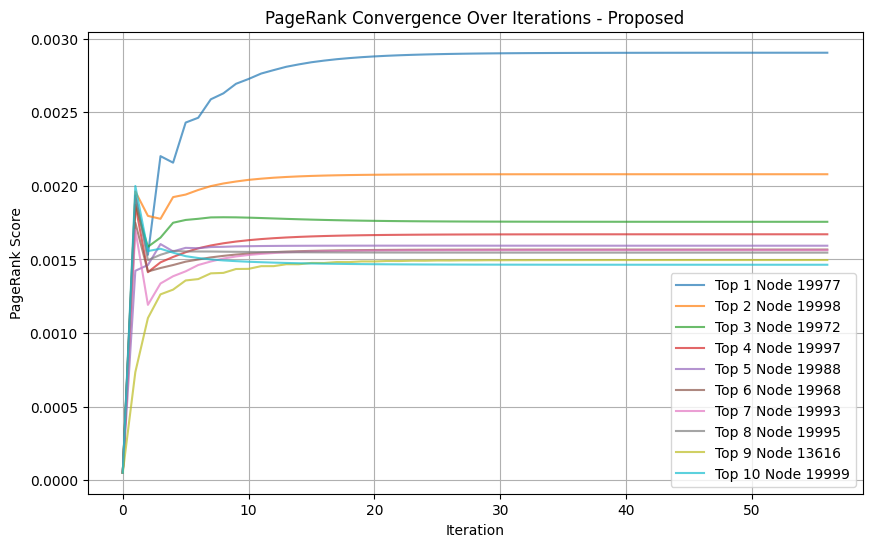

In [ ]:
plot_convergence(conv_tracking_sw, top_nodes_sw, 'Proposed',)

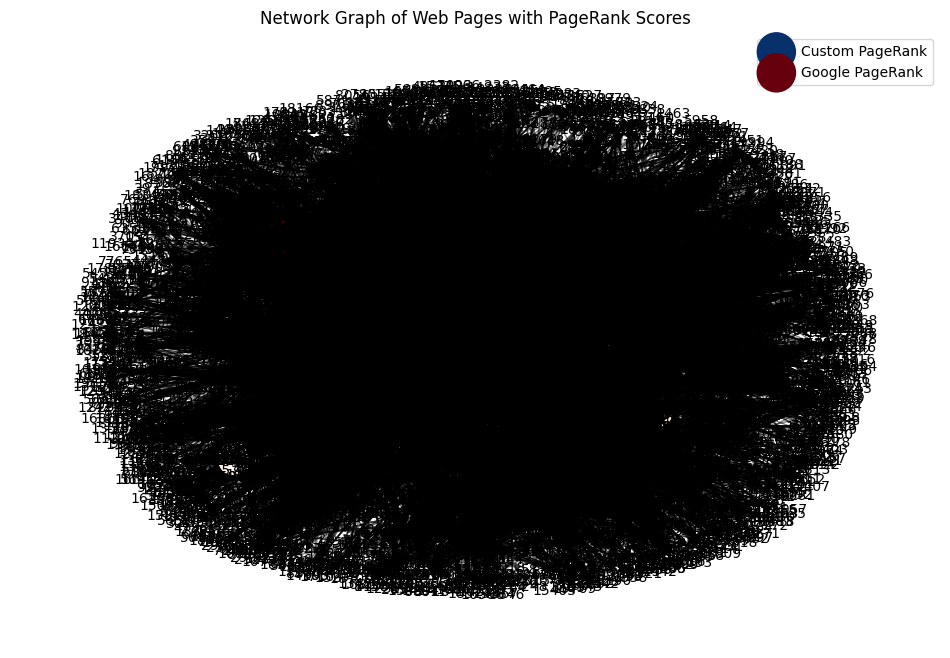

In [ ]:
plot_network_graph(adjacency_matrix, node_pagerank_sw, node_pagerank_google, top_nodes_sw, top_nodes_google)

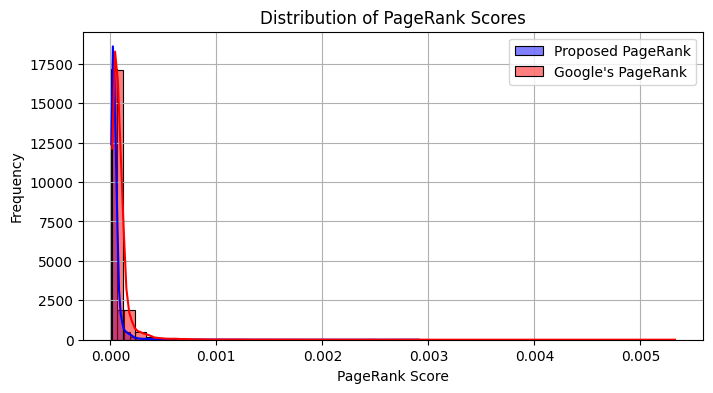

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(pr_scores_sw, bins=50, kde=True, color='blue', label='Proposed PageRank')
sns.histplot(pr_scores_google, bins=50, kde=True, color='red', label="Google's PageRank")
plt.title('Distribution of PageRank Scores')
plt.xlabel('PageRank Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

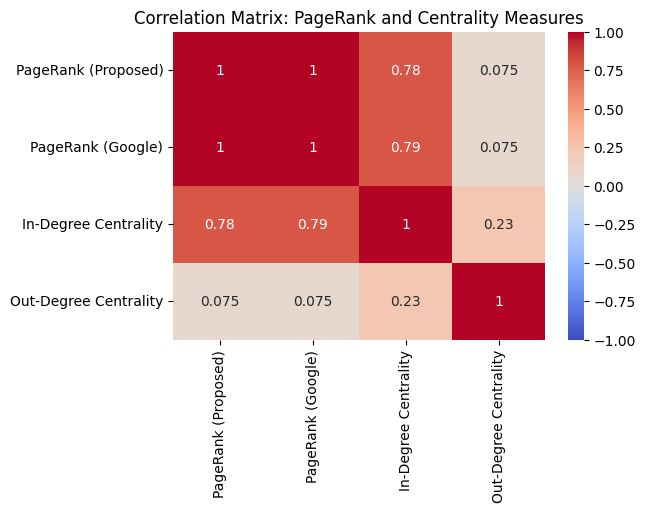

In [ ]:
G = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

in_degree_centrality = nx.in_degree_centrality(G)
in_degree_values = np.array([in_degree_centrality[node] for node in G.nodes()])

out_degree_centrality = nx.out_degree_centrality(G)
out_degree_values = np.array([out_degree_centrality[node] for node in G.nodes()])

pr_scores_sw_nx = nx.pagerank(G, alpha=0.85)
data = {
    'PageRank (Proposed)': pr_scores_sw,
    'PageRank (Google)': pr_scores_google,
    'In-Degree Centrality': in_degree_values,
    'Out-Degree Centrality': out_degree_values
}
df_centralities = pd.DataFrame(data)
corr_matrix = df_centralities.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix: PageRank and Centrality Measures')
plt.show()

In [ ]:
def compute_reaching_probability(G, top_nodes, pagerank_scores):
    reaching_probabilities = {}
    for node_id, _ in top_nodes:
        node_reaching_prob = 0
        for start_node in G.nodes():
            try:
                shortest_path_length = nx.shortest_path_length(G, source=start_node, target=node_id)
                if shortest_path_length == 0:
                    continue
                node_reaching_prob += pagerank_scores[start_node] / shortest_path_length
            except nx.NetworkXNoPath:
                continue
        reaching_probabilities[node_id] = node_reaching_prob
    return reaching_probabilities

In [ ]:
G = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

reaching_probabilities_sw = compute_reaching_probability(G, top_nodes_sw, pr_scores_sw)
reaching_probabilities_google = compute_reaching_probability(G, top_nodes_google, pr_scores_google)

print("Reaching Probabilities using Proposed PageRank:")
for node_id, prob in reaching_probabilities_sw.items():
    print(f"Node ID: {node_id}, Reaching Probability: {prob:.4f}")



Reaching Probabilities using Proposed PageRank:
Node ID: 19977, Reaching Probability: 0.0889
Node ID: 19998, Reaching Probability: 0.0825
Node ID: 19972, Reaching Probability: 0.0901
Node ID: 19997, Reaching Probability: 0.0794
Node ID: 19988, Reaching Probability: 0.0750
Node ID: 19968, Reaching Probability: 0.0891
Node ID: 19993, Reaching Probability: 0.0861
Node ID: 19995, Reaching Probability: 0.0808
Node ID: 13616, Reaching Probability: 0.0038
Node ID: 19999, Reaching Probability: 0.0803
